# Feature explanations analysis

In [1]:
import sverad.feature_importance as feim
from itertools import product
from sverad.utils import set_seeds
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import makedirs
from os.path import exists
from tqdm.notebook import tqdm
# import pickle
import dill
from rdkit import Chem
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score

In [2]:
SEED = 42
set_seeds(SEED)

# Defining assessed target and test-training split
dataset_name = "P0DMS8"
trial = 0

SAVE_FIGURES_PATH = f"./data/figures/{dataset_name}/"
SAVE_MAPPING_PATH = f"./data/figures/{dataset_name}/shapley_values_mapping/"
SAVE_PLOTS = True
SAVE_MAPPING = False
FIGURE_FORMAT = "pdf"


In [3]:
mpl.rcParams.update({'font.size': 14})

## Loading the data

In [4]:
dataset_df = pd.read_csv("./data/dataset.tsv", sep="\t")

In [5]:
dataset_df.pivot_table(index="uniprot_id", columns="label", values="nonstereo_aromatic_smiles", aggfunc="nunique", fill_value=0)

label,active,random
uniprot_id,,
P0DMS8,287,287


In [6]:
dataset_dict = None
fingerprint_gen_dict = None
shap_dict = None
obtained_models = None
with open("./data/pickle/dataset_dict.p", "rb") as infile:
    dataset_dict = dill.load(infile)
with open("./data/pickle/fingerprint_gen_dict.p", "rb") as infile:
    fingerprint_gen_dict = dill.load(infile)
with open("./data/pickle/shap_dict.p", "rb") as infile:
    shap_dict = dill.load(infile)
with open("./data/pickle/obtained_models.p", "rb") as infile:
    obtained_models = dill.load(infile)
prediction_df = pd.read_csv("./data/prediction_df.tsv", sep="\t")

In [7]:
print("Best params for SVM:", obtained_models['P0DMS8',0, 'SVC'].best_params_)
print("Best params for RF:", obtained_models['P0DMS8',0, 'RF'].best_params_)

Best params for SVM: {'C': 10, 'gamma_value': 0.01}
Best params for RF: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [8]:
svc_model = obtained_models[(dataset_name, trial, "SVC")]
support_vectors = svc_model.best_estimator_.explicit_support_vectors


num_samples = dataset_dict[dataset_name].feature_matrix.shape[0]
avg_intesecting = []
avg_diff = []
avg_union = []
for i in range(num_samples):
    vector = dataset_dict[dataset_name].feature_matrix[i, :]
    repeated_vector = vector[np.zeros(support_vectors.shape[0]), :]
    intersecting_f = vector.multiply(support_vectors)
    only_vector = repeated_vector - intersecting_f
    only_support = support_vectors - intersecting_f

    n_shared = intersecting_f.sum(axis=1)
    n_only_v = only_vector.sum(axis=1)
    n_only_sv = only_support.sum(axis=1)

    n_difference = n_only_v + n_only_sv
    n_union_features = n_shared + n_difference

    avg_intesecting.append(n_shared.mean())
    avg_diff.append(n_difference.mean())
    avg_union.append(n_union_features.mean())


print(f"Average number of intersecting features: {np.mean(avg_intesecting)}")
print(f"Average number of symmetric difference features: {np.mean(avg_diff)}")
print(f"Average number of union features: {np.mean(avg_union)}")
    

Average number of intersecting features: 10.776881720430106
Average number of symmetric difference features: 86.32162526694391
Average number of union features: 97.09850698737402


## Model performances

In [9]:
for data_set_name, dataset_grpd_df in prediction_df.groupby(["dataset_name"]):
    for (algorithm, traininset), split_df in prediction_df.groupby(["algorithm", "trainingset"]):
        split_name = "training set" if traininset else "test set"
        print("{} - {}: {:0.2f}".format(algorithm, split_name, balanced_accuracy_score(split_df.label, split_df.prediction)))

RF - test set: 0.92
RF - training set: 1.00
SVC - test set: 0.93
SVC - training set: 1.00


# Analysis

### Setting up variables for analysis

In [10]:
trial_df = prediction_df.query("dataset_name == @dataset_name & trial == @trial")
fingerprint = fingerprint_gen_dict[dataset_name]
dataset = dataset_dict[dataset_name]

svc = obtained_models[(dataset_name, trial, "SVC")].best_estimator_


svc_shapley = shap_dict[(dataset_name, trial, "SVC")]["sverad_values"]
svc_SHAP = shap_dict[(dataset_name, trial, "SVC")]["kernel_shap_values"]
svc_shapley_E = shap_dict[(dataset_name, trial, "SVC")]["expected_value"]
svc_SHAP_E = shap_dict[(dataset_name, trial, "SVC")]["kernel_expected_value"]

rf_shapley = shap_dict[(dataset_name, trial, "RF")]["tree_shap_values"]
rf_SHAP = shap_dict[(dataset_name, trial, "RF")]["kernel_shap_values"]
rf_shapley_E = shap_dict[(dataset_name, trial, "RF")]["expected_value"]
rf_SHAP_E = shap_dict[(dataset_name, trial, "RF")]["kernel_expected_value"]

### Expected values

In [11]:
print("SVM expected values: ", svc.expected_value[0])
print("RF expected value", shap_dict[(dataset_name, trial, "RF")]["expected_value"])

SVM expected values:  -4.612943402207797
RF expected value 0.49364000000000025


In [12]:
if not exists(SAVE_FIGURES_PATH):
    makedirs(SAVE_FIGURES_PATH)
if not exists(SAVE_MAPPING_PATH):
    makedirs(SAVE_MAPPING_PATH)

### Predicted log-odds of the SVM

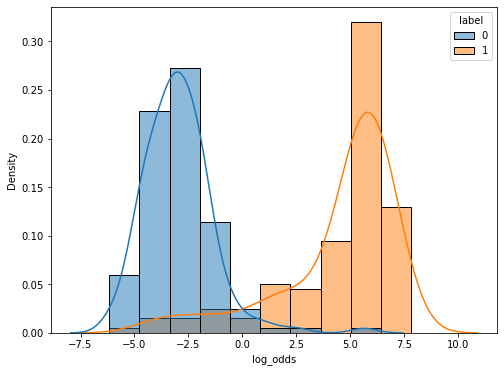

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(data=trial_df.query("testset").query("algorithm == 'SVC'"), x="log_odds", hue="label", ax=ax, common_norm=False)
sns.histplot(data=trial_df.query("testset").query("algorithm == 'SVC'"), x="log_odds", hue="label", ax=ax, common_norm=False, stat="density")
if SAVE_PLOTS: 
    plt.savefig(SAVE_FIGURES_PATH + "predicted_log_odds_SVM." + FIGURE_FORMAT, dpi=300)

## Absence and presence of features

### Defining assessed compounds and transforming the dataframe for analysis

In [14]:
correct_predicted_df = trial_df.query("label == prediction & testset")

In [15]:
correct_predicted_df_molten = correct_predicted_df.melt(id_vars=["nonstereo_aromatic_smiles", "dataset_idx", "label", "algorithm"],
                                                        value_vars=["present_shap", "absent_shap", "kernel_present_shap", "kernel_absent_shap"],
                                                        value_name="Shapley sum")

In [16]:
# Renaming the columns from 0 and 1 to random and active, respectively.
correct_predicted_df_molten["label_str"] = "Random"
correct_predicted_df_molten.loc[correct_predicted_df_molten["label"] == 1, "label_str"] = "Active"

correct_predicted_df_molten["variable_str"] = ""
correct_predicted_df_molten.loc[correct_predicted_df_molten.variable == "present_shap", "variable_str"] = "Present features"
correct_predicted_df_molten.loc[correct_predicted_df_molten.variable == "absent_shap", "variable_str"] = "Absent features"

### SVs for SVM using SVERAD

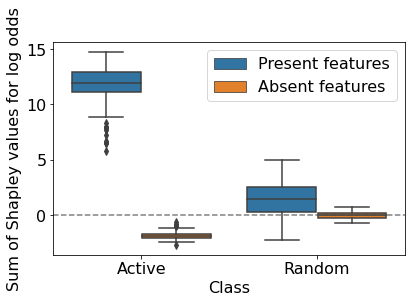

In [17]:
mpl.rcParams.update({'font.size': 16})
fig, ax = plt.subplots() #fig, ax = plt.subplots() edited to save in larger plot
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'SVC'"), x="label_str", hue="variable_str", y="Shapley sum", hue_order=["Present features", "Absent features"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
ax.set_xlim(xlim)
# ax.set_title("SVM")

ax.set_xlabel("Class")
ax.set_ylabel(r"Sum of Shapley values for log odds")
ax.legend(*ax.get_legend_handles_labels())
plt.tight_layout() #added to save in larger plot. Remove if not needed
if SAVE_PLOTS:
    plt.savefig(SAVE_FIGURES_PATH + "boxplot_present_absent_sverad_svm." + FIGURE_FORMAT, dpi=300, bbox_inches='tight') #bbox_inches='tight'used with plt.tight_layout() to save in larger plot

#### Contributions of all features of active compounds.

In [18]:
print("Avg sum of SVs for SVM active", correct_predicted_df.query("algorithm == 'SVC' & label == 1")[["present_shap", "absent_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'SVC' & label == 1")[["present_shap", "absent_shap"]].sum(axis=1).std())

print("Avg sum of SVs for RF random", correct_predicted_df.query("algorithm == 'RF' & label == 1")[["present_shap", "absent_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'RF' & label == 1")[["present_shap", "absent_shap"]].sum(axis=1).std())

Avg sum of SVs for SVM active 9.854801102769395
Std dev 1.591035832013597
Avg sum of SVs for RF random 0.44221125885425805
Std dev 0.1156114702939115


##### Contribution of present features

In [19]:
print("Avg sum of SVs for SVM active", correct_predicted_df.query("algorithm == 'SVC' & label == 1")[["present_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'SVC' & label == 1")[["present_shap"]].sum(axis=1).std())

print("Avg sum of SVs for RF random", correct_predicted_df.query("algorithm == 'RF' & label == 1")[["present_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'RF' & label == 1")[["present_shap"]].sum(axis=1).std())

Avg sum of SVs for SVM active 11.647396186917756
Std dev 1.8444892482647164
Avg sum of SVs for RF random 0.5136096327097945
Std dev 0.06756434511318411


##### Contribution of absent features

In [20]:
print("Avg sum of SVs for SVM active", correct_predicted_df.query("algorithm == 'SVC' & label == 1")[["absent_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'SVC' & label == 1")[["absent_shap"]].sum(axis=1).std())

print("Avg sum of SVs for RF random", correct_predicted_df.query("algorithm == 'RF' & label == 1")[["absent_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'RF' & label == 1")[["absent_shap"]].sum(axis=1).std())

Avg sum of SVs for SVM active -1.7925950841483604
Std dev 0.33155419439719264
Avg sum of SVs for RF random -0.0713983738555365
Std dev 0.05105619746761544


#### Contributions of all features of random compounds.

In [21]:
print("Avg sum of SVs for SVM random", correct_predicted_df.query("algorithm == 'SVC' & label == 0")[["present_shap", "absent_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'SVC' & label == 0")[["present_shap", "absent_shap"]].sum(axis=1).std())

print("Avg sum of SVs for RF random", correct_predicted_df.query("algorithm == 'RF' & label == 0")[["present_shap", "absent_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'RF' & label == 0")[["present_shap", "absent_shap"]].sum(axis=1).std())

Avg sum of SVs for SVM random 1.454511635812159
Std dev 1.235159344015524
Avg sum of SVs for RF random -0.38246519193235673
Std dev 0.08532732025898816


##### Contribution of present features

In [22]:
print("Avg sum of SVs for SVM random", correct_predicted_df.query("algorithm == 'SVC' & label == 0")[["present_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'SVC' & label == 0")[["present_shap"]].sum(axis=1).std())

print("Avg sum of SVs for RF random", correct_predicted_df.query("algorithm == 'RF' & label == 0")[["present_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'RF' & label == 0")[["present_shap"]].sum(axis=1).std())

Avg sum of SVs for SVM random 1.4625315043801261
Std dev 1.5132885207511246
Avg sum of SVs for RF random 0.018121009508343017
Std dev 0.05163269170804077


##### Contribution of absent features

In [23]:
print("Avg sum of SVs for SVM random", correct_predicted_df.query("algorithm == 'SVC' & label == 0")[["absent_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'SVC' & label == 0")[["absent_shap"]].sum(axis=1).std())

print("Avg sum of SVs for RF random", correct_predicted_df.query("algorithm == 'RF' & label == 0")[["absent_shap"]].sum(axis=1).mean())
print("Std dev", correct_predicted_df.query("algorithm == 'RF' & label == 0")[["absent_shap"]].sum(axis=1).std())

Avg sum of SVs for SVM random -0.008019868567967124
Std dev 0.322841713285829
Avg sum of SVs for RF random -0.40058620144069973
Std dev 0.03855759318694538


### Kernel-SHAP of SVM
Not part of publication.

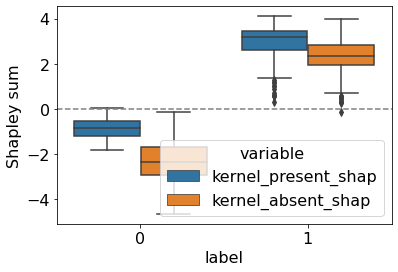

In [24]:
fig, ax = plt.subplots()
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'SVC'"), x="label", hue="variable", y="Shapley sum", hue_order=["kernel_present_shap", "kernel_absent_shap"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
ax.set_xlim(xlim)
if SAVE_PLOTS: 
    plt.savefig(SAVE_FIGURES_PATH + "boxplot_present_absent_shap_svm_kernel_shap." + FIGURE_FORMAT, dpi=300)

### SVs for RF using TreeExplainer

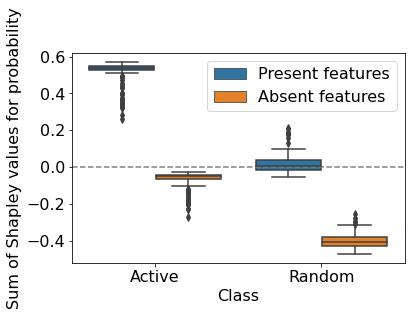

In [25]:
mpl.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'RF'"), x="label_str", hue="variable_str", y="Shapley sum", hue_order=["Present features", "Absent features"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
# ax.set_title("RF")

ax.set_xlim(xlim)
ax.set_xlabel("Class")
ax.set_ylabel(r"Sum of Shapley values for probability")
ax.legend(*ax.get_legend_handles_labels())
plt.tight_layout()
if SAVE_PLOTS:
    plt.savefig(SAVE_FIGURES_PATH + "boxplot_present_absent_SVs_TF_TreeExplainer." + FIGURE_FORMAT, dpi=300, bbox_inches='tight') #bbox_inches='tight'

### Kernel-SHAP of RF

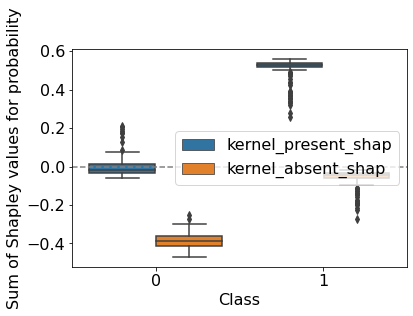

In [26]:
fig, ax = plt.subplots()
sns.boxplot(data=correct_predicted_df_molten.query("algorithm == 'RF'"), x="label", hue="variable", y="Shapley sum", hue_order=["kernel_present_shap", "kernel_absent_shap"])
xlim = ax.get_xlim()
ax.hlines(0, *xlim, color="gray", ls="--")
ax.set_xlim(xlim)
ax.set_xlabel("Class")
ax.set_ylabel(r"Sum of Shapley values for probability")
ax.legend(*ax.get_legend_handles_labels())
if SAVE_PLOTS:
    plt.savefig(SAVE_FIGURES_PATH + "boxplot_present_absent_shap_rf_kernel_shap." + FIGURE_FORMAT, dpi=300)

## Correlation between models and explanations

In [27]:
correlation_df = []
# all_contributions = [("SVs SVM", svc_shapley),
#                      ("SHAP values SVM", svc_SHAP),
#                      ("SVs RF", rf_shapley),
#                      ("SHAP values RF", rf_SHAP),
#                     ] 
all_contributions = [("SVM - SVERAD", svc_shapley),
                     ("SVM - KernelSHAP", svc_SHAP),
                     ("RF - TreeSHAP", rf_shapley),
                     ("RF - KernelSHAP", rf_SHAP),
                    ]
for i, row in trial_df.query("algorithm == 'SVC'").iterrows():
    for (alg1, values1), (alg2, values2) in product(all_contributions, repeat=2):
        corr, p = pearsonr(values1[row["dataset_idx"]], values2[row["dataset_idx"]])
        correlation_df.append({"algorithm1": alg1,
                               "algorithm2": alg2,
                               "nonstereo_aromatic_smiles": row["nonstereo_aromatic_smiles"],
                               "label": row["label"],
                               "dataset_idx": row["dataset_idx"],
                               "trainingset": row["trainingset"],

                               "corrleation": corr,
                              })
correlation_df = pd.DataFrame(correlation_df)
correlation_df["pearsons_r_fisher"] = np.arctanh(correlation_df.corrleation)
correlation_df["datasetlabel"] = "Testset"
correlation_df.loc[correlation_df["trainingset"], "datasetlabel"] = "Trainingset"

/home/mastro/anaconda3/envs/sveta/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in arctanh
  result = getattr(ufunc, method)(*inputs, **kwargs)


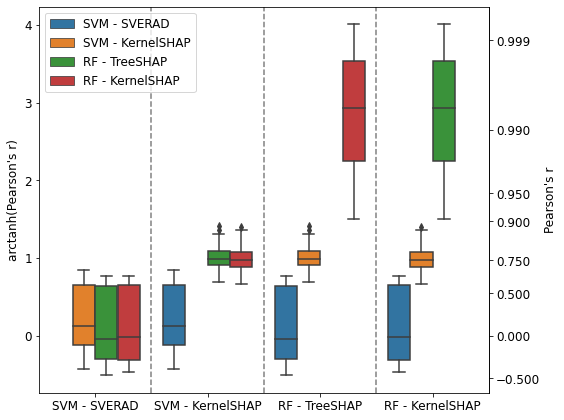

In [28]:
mpl.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=correlation_df.query("algorithm1 != algorithm2 & datasetlabel == 'Testset'"), x="algorithm1", y="pearsons_r_fisher", hue="algorithm2", hue_order=["SVM - SVERAD", "SVM - KernelSHAP", "RF - TreeSHAP", "RF - KernelSHAP"], ax=ax)
ylim= ax.get_ylim()
ax.vlines(0.5, *ylim, color="gray", ls="--")
ax.vlines(1.5, *ylim, color="gray", ls="--")
ax.vlines(2.5, *ylim, color="gray", ls="--")

ax.set_ylim(*ylim)
ax.set_xlim(-0.5, 3.5)
ax.set_ylabel("arctanh(Pearson's r)")
secax = ax.secondary_yaxis('right', functions=(np.tanh, np.arctanh))
secax.set_ylabel("Pearson's r")
secax.set_yticks([-0.5, 0, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]);
ax.set_xlabel("")
ax.legend(*ax.get_legend_handles_labels())
plt.tight_layout()
if SAVE_PLOTS:
    plt.savefig(SAVE_FIGURES_PATH + "correlation_model_explanations." + FIGURE_FORMAT, dpi=300, bbox_inches='tight')
# mpl.rcParams.update({'font.size': 12})

Computing statistics

In [29]:
print("Mean correlation coefficients:")
display(correlation_df.query("algorithm1 != algorithm2 & datasetlabel == 'Testset'").pivot_table(index="algorithm1", columns="algorithm2", values="pearsons_r_fisher", aggfunc="mean").apply(np.tanh))
print("Standard deviation of correlation coefficients:")
display(correlation_df.query("algorithm1 != algorithm2 & datasetlabel == 'Testset'").pivot_table(index="algorithm1", columns="algorithm2", values="pearsons_r_fisher", aggfunc="std").apply(np.tanh))
print("Median correlation coefficients:")   
display(correlation_df.query("algorithm1 != algorithm2 & datasetlabel == 'Testset'").pivot_table(index="algorithm1", columns="algorithm2", values="pearsons_r_fisher", aggfunc="median").apply(np.tanh))

Mean correlation coefficients:


algorithm2,RF - KernelSHAP,RF - TreeSHAP,SVM - KernelSHAP,SVM - SVERAD
algorithm1,,,,
RF - KernelSHAP,NaN,0.993863,0.752305,0.127390
RF - TreeSHAP,0.993863,NaN,0.760898,0.118826
SVM - KernelSHAP,0.752305,0.760898,NaN,0.227592
SVM - SVERAD,0.127390,0.118826,0.227592,NaN


Standard deviation of correlation coefficients:


algorithm2,RF - KernelSHAP,RF - TreeSHAP,SVM - KernelSHAP,SVM - SVERAD
algorithm1,,,,
RF - KernelSHAP,NaN,0.596273,0.134336,0.429066
RF - TreeSHAP,0.596273,NaN,0.125936,0.427885
SVM - KernelSHAP,0.134336,0.125936,NaN,0.368404
SVM - SVERAD,0.429066,0.427885,0.368404,NaN


Median correlation coefficients:


algorithm2,RF - KernelSHAP,RF - TreeSHAP,SVM - KernelSHAP,SVM - SVERAD
algorithm1,,,,
RF - KernelSHAP,NaN,0.994369,0.749896,-0.009969
RF - TreeSHAP,0.994369,NaN,0.757887,-0.040150
SVM - KernelSHAP,0.749896,0.757887,NaN,0.120086
SVM - SVERAD,-0.009969,-0.040150,0.120086,NaN


## Mapping of present features
### Selecting the first compound

In [30]:
vis_cpd_idx = 4 #160
vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
trial_df.query("nonstereo_aromatic_smiles == @vis_cpd_smiles")

,nonstereo_aromatic_smiles,dataset_idx,label,prediction,log_odds,proba,trainingset,testset,trial,dataset_name,algorithm,present_shap,absent_shap,kernel_present_shap,kernel_absent_shap
4,CC(C)(C)NC(=O)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3c...,4,1,1,7.088429,0.999166,False,True,0,P0DMS8,SVC,13.837260,-2.135887,3.386163,3.649117
578,CC(C)(C)NC(=O)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3c...,4,1,1,NaN,1.000000,False,True,0,P0DMS8,RF,0.539933,-0.033573,0.529513,-0.023153


### SVM explanation

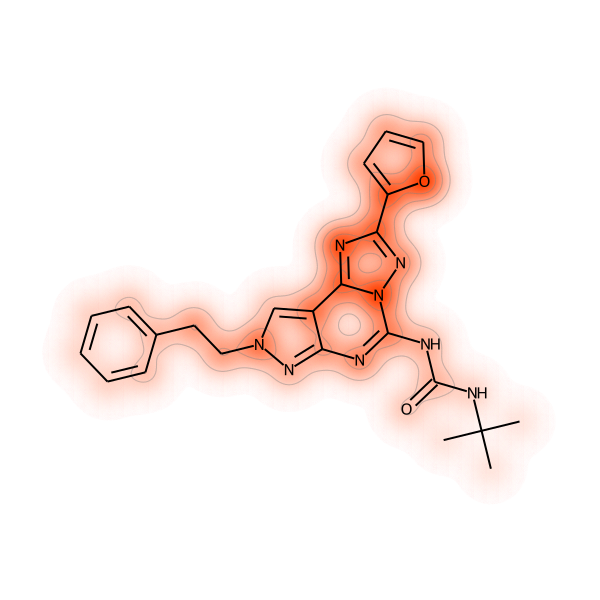

In [31]:
# Creating a RDKit mol object
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
# Determining SVs of present features (absent features cannot be mapped, as they are ... absent)
svr_present_shap = svc_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
# Mapping SVs to atoms
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
# Generating the figure.
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
if SAVE_MAPPING:
    fig.save(SAVE_MAPPING_PATH + str(vis_cpd_idx) + "_" + vis_cpd_smiles + "_SVM.png", dpi=(300,300))
display(fig)

### RF explanation

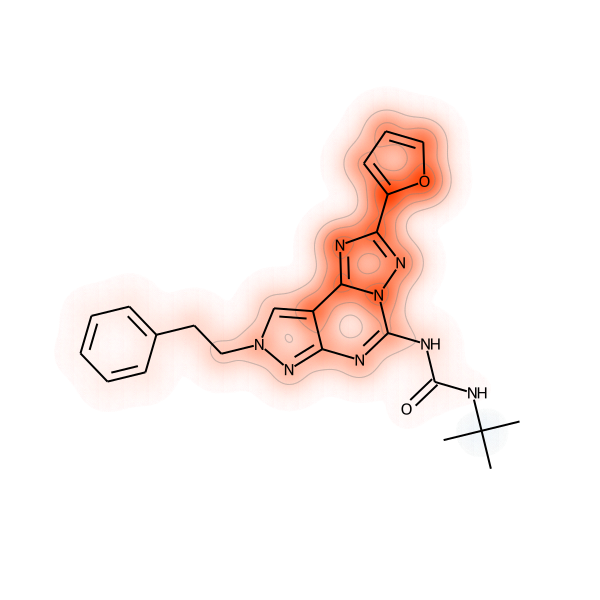

In [32]:
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
svr_present_shap = rf_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
if SAVE_MAPPING:
    fig.save(SAVE_MAPPING_PATH + str(vis_cpd_idx) + "_" + vis_cpd_smiles + "_RF.png", dpi=(300,300))
display(fig)

### Selecting the second CPD

In [33]:
vis_cpd_idx = 75
vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
trial_df.query("nonstereo_aromatic_smiles == @vis_cpd_smiles")

,nonstereo_aromatic_smiles,dataset_idx,label,prediction,log_odds,proba,trainingset,testset,trial,dataset_name,algorithm,present_shap,absent_shap,kernel_present_shap,kernel_absent_shap
75,CCCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc2...,75,1,1,7.92427,0.999638,True,False,0,P0DMS8,SVC,14.810743,-2.273530,4.015991,3.855129
649,CCCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc2...,75,1,1,NaN,1.000000,True,False,0,P0DMS8,RF,0.536943,-0.030583,0.530376,-0.024016


### SVM explanation

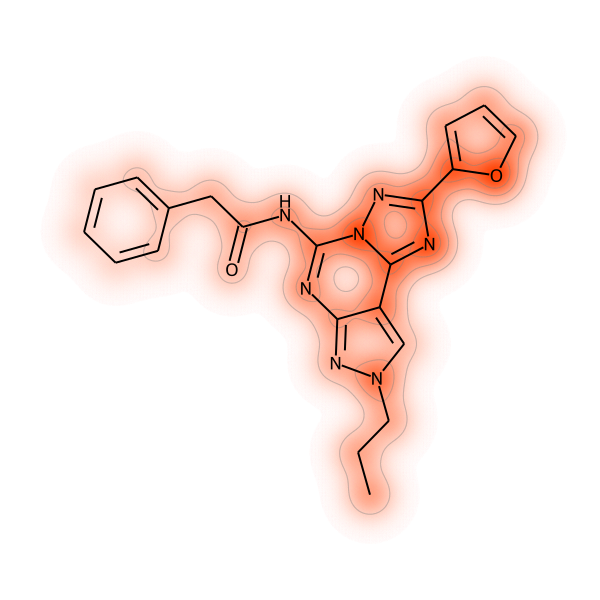

In [34]:
trial_df.query("nonstereo_aromatic_smiles == @vis_cpd_smiles")
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
svr_present_shap = svc_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
if SAVE_MAPPING:
    fig.save(SAVE_MAPPING_PATH + str(vis_cpd_idx) + "_" + vis_cpd_smiles + "_SVM.png", dpi=(300,300))
display(fig)

### RF explanation

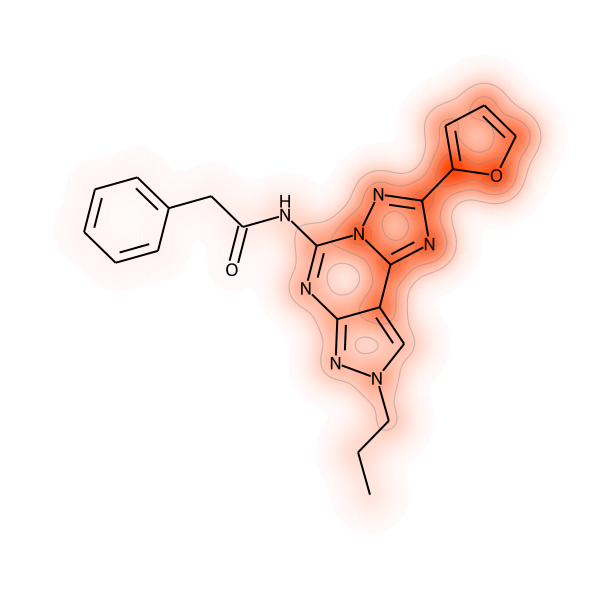

In [35]:
vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
svr_present_shap = rf_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
fig = feim.show_png(svg_image.GetDrawingText())
if SAVE_MAPPING:
    fig.save(SAVE_MAPPING_PATH + str(vis_cpd_idx) + "_" + vis_cpd_smiles + "_RF.png", dpi=(300,300))
display(fig)

### Generating mapping for all the correctly predicted test cpds

In [36]:
if SAVE_MAPPING:
    if not exists(SAVE_MAPPING_PATH + "active/"):
        makedirs(SAVE_MAPPING_PATH + "active/")

    #for SVERAD SVM
    test_active_df_SVM = trial_df.query("testset & label == 1 & prediction == 1 & algorithm == 'SVC'")
    for i, row in tqdm(test_active_df_SVM.iterrows(), total=len(test_active_df_SVM)):
        vis_cpd_idx = row["dataset_idx"]
        vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
        vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
        svr_present_shap = svc_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
        atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
        svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
        fig = feim.show_png(svg_image.GetDrawingText())
        fig.save(SAVE_MAPPING_PATH + "active/SVM_SVERAD_"+ str(vis_cpd_idx) + "_" + vis_cpd_smiles + ".png", dpi=(300,300))
        
    # for TreeExplainer RF
    test_active_df_SVM_RF = trial_df.query("testset & label == 1 & prediction == 1 & algorithm == 'RF'")
    for i, row in tqdm(test_active_df_SVM_RF.iterrows(), total=len(test_active_df_SVM_RF)):
        vis_cpd_idx = row["dataset_idx"]
        vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
        vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
        svr_present_shap = rf_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
        atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
        svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
        fig = feim.show_png(svg_image.GetDrawingText())
        fig.save(SAVE_MAPPING_PATH + "active/RF_TreeSHAP_"+ str(vis_cpd_idx) + "_" + vis_cpd_smiles + ".png", dpi=(300,300))


In [37]:
if SAVE_MAPPING:
    if not exists(SAVE_MAPPING_PATH + "random/"):
        makedirs(SAVE_MAPPING_PATH + "random/")

    #for SVERAD SVM
    test_random_df_SVM = trial_df.query("testset & label == 0 & prediction == 0 & algorithm == 'SVC'")
    for i, row in tqdm(test_random_df_SVM.iterrows(), total=len(test_random_df_SVM)):
        vis_cpd_idx = row["dataset_idx"]
        vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
        vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
        svr_present_shap = svc_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
        atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
        svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
        fig = feim.show_png(svg_image.GetDrawingText())
        fig.save(SAVE_MAPPING_PATH + "random/SVM_SVERAD_"+ str(vis_cpd_idx) + "_" + vis_cpd_smiles + ".png", dpi=(300,300))
        
    # for TreeExplainer RF
    test_random_df_RF = trial_df.query("testset & label == 0 & prediction == 0 & algorithm == 'RF'")
    for i, row in tqdm(test_random_df_RF.iterrows(), total=len(test_random_df_RF)):
        vis_cpd_idx = row["dataset_idx"]
        vis_cpd_smiles = dataset.nonstereo_aromatic_smiles[vis_cpd_idx]
        vis_cpd_mol_obj = Chem.MolFromSmiles(vis_cpd_smiles)
        svr_present_shap = rf_shapley[vis_cpd_idx] * dataset.feature_matrix.toarray()[vis_cpd_idx]
        atomweight_svr = feim.shap2atomweight(vis_cpd_mol_obj, fingerprint, svr_present_shap)
        svg_image = feim.rdkit_gaussplot(vis_cpd_mol_obj, atomweight_svr, n_contourLines=5)
        fig = feim.show_png(svg_image.GetDrawingText())
        fig.save(SAVE_MAPPING_PATH + "random/RF_TreeSHAP_"+ str(vis_cpd_idx) + "_" + vis_cpd_smiles + ".png", dpi=(300,300))